In [2]:
#count number of image types
import os
import numpy as np

root_dir = os.getcwd()
total_covid_files = 0
total_normal_files = 0
total_pneumonia_files = 0

for base, dirs, files in os.walk(root_dir + '/COVID'):
    for Files in files:
        total_covid_files += 1
        
for base, dirs, files in os.walk(root_dir + '/Normal'):
    for Files in files:
        total_normal_files += 1

for base, dirs, files in os.walk(root_dir + '/Viral Pneumonia'):
    for Files in files:
        total_pneumonia_files += 1


In [3]:
#establish root, training and validation directories for image types
all_covid_dir = os.path.join(root_dir, 'COVID')
all_normal_dir = os.path.join(root_dir, 'Normal')
all_pneumonia_dir = os.path.join(root_dir, 'Viral Pneumonia')

train_dir = os.path.join(root_dir, 'train_imgs')
valid_dir = os.path.join(root_dir, 'valid_imgs')

train_covid_dir = os.path.join(train_dir, 'COVID')
train_normal_dir = os.path.join(train_dir, 'Normal')
train_pneumonia_dir = os.path.join(train_dir, 'Viral Pneumonia')
valid_covid_dir = os.path.join(valid_dir, 'COVID')
valid_normal_dir = os.path.join(valid_dir, 'Normal')
valid_pneumonia_dir = os.path.join(valid_dir, 'Viral Pneumonia')

In [4]:
import cv2
import random
cv_filename = all_covid_dir + '\COVID-' + str(1) + '.png'
image = cv2.imread(cv_filename)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)

ss.switchToSelectiveSearchFast()
rects = ss.process()

# loop over the region proposals in chunks (so we can better
# visualize them)
for i in range(0, len(rects), 100):
	# clone the original image so we can draw on it
	output = image.copy()
	# loop over the current subset of region proposals
	for (x, y, w, h) in rects[i:i + 100]:
		# draw the region proposal bounding box on the image
		color = [random.randint(0, 255) for j in range(0, 3)]
		cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
	# show the output image
	cv2.imshow("Output", output)
	key = cv2.waitKey(0) & 0xFF
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

In [91]:
#sample images of each type to be split into training and validation sets
sample_size = 1000
train_ratio = 0.8

training_size = int(sample_size*train_ratio)
valid_size = sample_size - training_size

covid_train = list(np.random.choice(range(total_covid_files), sample_size, replace=False))
normal_train = list(np.random.choice(range(total_normal_files), sample_size, replace=False))
pneumonia_train = list(np.random.choice(range(total_pneumonia_files), sample_size, replace=False))
covid_valid = []
normal_valid = []
pneumonia_valid = []

for i in range(valid_size):
    covid_index = np.random.choice(covid_train)
    normal_index = np.random.choice(normal_train)
    pneumonia_index = np.random.choice(pneumonia_train)
    
    covid_valid.append(covid_index)
    covid_train.remove(covid_index)
    normal_valid.append(normal_index)
    normal_train.remove(normal_index)
    pneumonia_valid.append(pneumonia_index)
    pneumonia_train.remove(pneumonia_index)

from shutil import copy

for index in covid_train:
    filename = all_covid_dir + '\COVID-' + str(index+1) + '.png'
    copy(filename, train_covid_dir)
    
for index in covid_valid:
    filename = all_covid_dir + '\COVID-' + str(index+1) + '.png'
    copy(filename, valid_covid_dir)
    
for index in normal_train:
    filename = all_normal_dir + '\\Normal-' + str(index+1) + '.png'
    copy(filename, train_normal_dir)
    
for index in normal_valid:
    filename = all_normal_dir + '\\Normal-' + str(index+1) + '.png'
    copy(filename, valid_normal_dir)
    
for index in pneumonia_train:
    filename = all_pneumonia_dir + '\Viral Pneumonia-' + str(index+1) + '.png'
    copy(filename, train_pneumonia_dir)
    
for index in pneumonia_valid:
    filename = all_pneumonia_dir + '\Viral Pneumonia-' + str(index+1) + '.png'
    copy(filename, valid_pneumonia_dir)

    

In [97]:
# Image pre-processing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=64,
        class_mode='categorical')

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        valid_dir,
        target_size=(299, 299),
        batch_size=64,
        class_mode='categorical')

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [4]:
# Binary CNN classifier using VGG model blocks

import sys
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


def build_CNN():
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(299, 299, 3)))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    cnn.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    cnn.add(Dense(3, activation='softmax'))
    cnn.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    return cnn

test_model = build_CNN()
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 149, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0

In [101]:
# fit the model
# history = model.fit_generator(
#       train_generator,
#       steps_per_epoch=100,  # 2000 images = batch_size * steps
#       epochs=15,
#       validation_data=validation_generator,
#       validation_steps=50,  # 1000 images = batch_size * steps
#       verbose=2)

history = test_model.fit_generator(
    train_generator, 
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator, 
    validation_steps=len(validation_generator), 
    epochs=20, 
    verbose=2)

Epoch 1/20
38/38 - 290s - loss: 4.2412 - accuracy: 0.6562 - val_loss: 0.3820 - val_accuracy: 0.8350
Epoch 2/20
38/38 - 278s - loss: 0.3275 - accuracy: 0.8763 - val_loss: 0.3193 - val_accuracy: 0.8867
Epoch 3/20
38/38 - 277s - loss: 0.2185 - accuracy: 0.9192 - val_loss: 0.2991 - val_accuracy: 0.8950
Epoch 4/20
38/38 - 284s - loss: 0.1474 - accuracy: 0.9446 - val_loss: 0.2724 - val_accuracy: 0.8983
Epoch 5/20
38/38 - 277s - loss: 0.0958 - accuracy: 0.9650 - val_loss: 0.3216 - val_accuracy: 0.8900
Epoch 6/20
38/38 - 280s - loss: 0.0686 - accuracy: 0.9771 - val_loss: 0.3405 - val_accuracy: 0.8967
Epoch 7/20
38/38 - 277s - loss: 0.0352 - accuracy: 0.9896 - val_loss: 0.3682 - val_accuracy: 0.9083
Epoch 8/20
38/38 - 278s - loss: 0.0160 - accuracy: 0.9946 - val_loss: 0.3816 - val_accuracy: 0.9067
Epoch 9/20
38/38 - 274s - loss: 0.0124 - accuracy: 0.9971 - val_loss: 0.3641 - val_accuracy: 0.9150
Epoch 10/20
38/38 - 279s - loss: 0.0076 - accuracy: 0.9996 - val_loss: 0.5369 - val_accuracy: 0.8933

Text(0.5, 1.0, 'Training and validation loss')

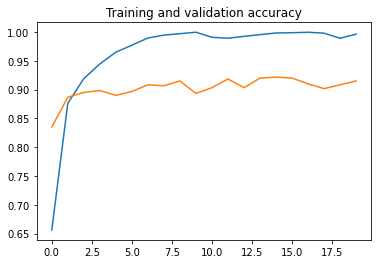

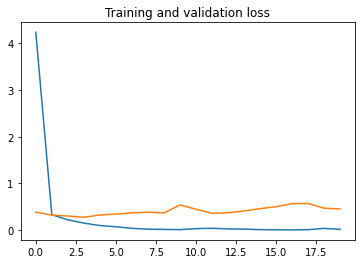

In [103]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [108]:
# attempting to decrease validation loss with dropout regularization techniques
from keras.layers import Dropout

def build_dropout_CNN():
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(299, 299, 3)))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    cnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    cnn.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(3, activation='softmax'))
    cnn.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    return cnn

dropout_model = build_dropout_CNN()

dropout_history = dropout_model.fit_generator(
    train_generator, 
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator, 
    validation_steps=len(validation_generator), 
    epochs=20, 
    verbose=2)

Epoch 1/20
38/38 - 324s - loss: 13.1919 - accuracy: 0.4158 - val_loss: 0.9612 - val_accuracy: 0.6550
Epoch 2/20
38/38 - 318s - loss: 0.8431 - accuracy: 0.6071 - val_loss: 0.7281 - val_accuracy: 0.7483
Epoch 3/20
38/38 - 318s - loss: 0.7089 - accuracy: 0.6904 - val_loss: 0.5773 - val_accuracy: 0.7967
Epoch 4/20
38/38 - 313s - loss: 0.6033 - accuracy: 0.7337 - val_loss: 0.5429 - val_accuracy: 0.8033
Epoch 5/20
38/38 - 311s - loss: 0.5368 - accuracy: 0.7812 - val_loss: 0.3596 - val_accuracy: 0.8567
Epoch 6/20
38/38 - 317s - loss: 0.4585 - accuracy: 0.8012 - val_loss: 0.3518 - val_accuracy: 0.8667
Epoch 7/20
38/38 - 364s - loss: 0.4042 - accuracy: 0.8454 - val_loss: 0.3433 - val_accuracy: 0.8667
Epoch 8/20
38/38 - 330s - loss: 0.3860 - accuracy: 0.8475 - val_loss: 0.3125 - val_accuracy: 0.8800
Epoch 9/20
38/38 - 331s - loss: 0.3497 - accuracy: 0.8621 - val_loss: 0.2857 - val_accuracy: 0.9050
Epoch 10/20
38/38 - 327s - loss: 0.3115 - accuracy: 0.8783 - val_loss: 0.2796 - val_accuracy: 0.910

Text(0.5, 1.0, 'Training and validation loss')

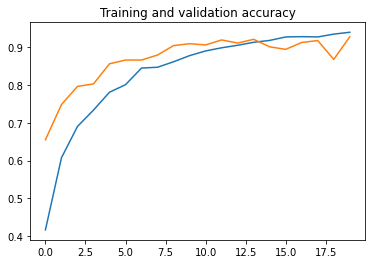

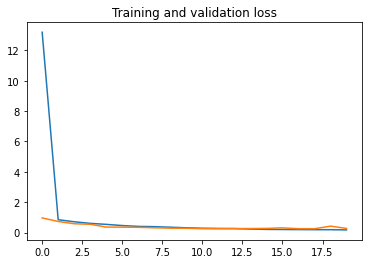

In [109]:
dropout_acc = dropout_history.history['accuracy']
dropout_val_acc = dropout_history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
dropout_loss = dropout_history.history['loss']
dropout_val_loss = dropout_history.history['val_loss']

# Get number of epochs
dropout_epochs = range(len(dropout_acc))

# Plot training and validation accuracy per epoch
plt.plot(dropout_epochs, dropout_acc)
plt.plot(dropout_epochs, dropout_val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(dropout_epochs, dropout_loss)
plt.plot(dropout_epochs, dropout_val_loss)
plt.title('Training and validation loss')

In [7]:
# image augmentation CNN

# Image pre-processing
aug_train_datagen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1,
                                  horizontal_flip=True)
aug_val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
aug_train_generator = aug_train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=64,
        class_mode='categorical')

# Flow validation images in batches using val_datagen generator
aug_validation_generator = aug_val_datagen.flow_from_directory(
        valid_dir,
        target_size=(299, 299),
        batch_size=64,
        class_mode='categorical')


Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [9]:
# fit the model with the new image augmentation and dropout regularization
from keras.layers import Dropout

def build_dropout_CNN():
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(299, 299, 3)))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    cnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    cnn.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(3, activation='softmax'))
    cnn.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    return cnn

aug_model = build_dropout_CNN()

aug_history = aug_model.fit_generator(
    aug_train_generator, 
    steps_per_epoch=len(aug_train_generator),
    validation_data=aug_validation_generator, 
    validation_steps=len(aug_validation_generator), 
    epochs=20, 
    verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
38/38 - 351s - loss: 13.3533 - accuracy: 0.4050 - val_loss: 0.9502 - val_accuracy: 0.5217
Epoch 2/20
38/38 - 344s - loss: 0.8909 - accuracy: 0.5596 - val_loss: 0.8065 - val_accuracy: 0.6083
Epoch 3/20
38/38 - 340s - loss: 0.7969 - accuracy: 0.6096 - val_loss: 0.7327 - val_accuracy: 0.6667
Epoch 4/20
38/38 - 340s - loss: 0.7420 - accuracy: 0.6404 - val_loss: 0.6944 - val_accuracy: 0.7100
Epoch 5/20
38/38 - 331s - loss: 0.7142 - accuracy: 0.6525 - val_loss: 0.5887 - val_accuracy: 0.7150
Epoch 6/20
38/38 - 330s - loss: 0.6952 - accuracy: 0.6492 - val_loss: 0.5964 - val_accuracy: 0.7283
Epoch 7/20
38/38 - 327s - loss: 0.6441 - accuracy: 0.6733 - val_loss: 0.6071 - val_accuracy: 0.7150
Epoch 8/20
38/38 - 325s - loss: 0.6422 - accuracy: 0.6875 - val_loss: 0.5386 - val_accuracy: 0.7500
Epoch 9/20
38/38 - 327s - loss: 0.6224 - accuracy: 0.7175 - val_loss: 0.5311 - val_accuracy: 0.7483
Epoch 10/20
38/38 - 330

KeyboardInterrupt: 